## HW02 Code

### Name: Eli Dow

You will complete the following notebook, as described in the PDF for Homework 02 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.  (This can be generated by printing the notebook as PDF, or using the **File -> Download as** menu.  If you have trouble with the latter, a nice approach is to download in Markdown format, and then use a Markdown reader to print to PDF, which tends to produce nicer results than does printing from a browser.)

In [116]:
# import libraries as needed
import numpy as np
import pandas as pd
import math

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

### Plotting function

**Do not modify the following**: it takes in a list of polynomial (integer) values, along with associated lists consisting of the predictions made for the associated model, and the resulting error, and plots the results in a grid.

In [117]:
def plot_predictions(polynomials=list(), prediction_list=list(), error_list=list()):
    '''Plot predicted results for a number of polynomial regression models
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model.
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    
        Note: it is expected that all lists are of the same length, and 
            that this length be some perfect square (for grid-plotting).
    '''
    length = len(prediction_list)
    grid_size = int(math.sqrt(length))
    if not (length == len(polynomials) and length == len(error_list)):
        raise ValueError("Input lists must be of same length")
    if not length == (grid_size * grid_size):
        raise ValueError("Need a square number of list items (%d given)" % (length))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize =(14,14), sharey=True)
    for subplot_id, prediction in enumerate(prediction_list):
        # order data for display
        data_frame = pd.DataFrame(data=[x[:, 0], prediction]).T
        data_frame = data_frame.sort_values(by=0)
        x_sorted = data_frame.iloc[:, :-1].values
        prediction_sorted = data_frame.iloc[:, 1].values

        ax = axs.flat[subplot_id]
        ax.set_title('degree = %d; MSE = %.3f' % (polynomials[subplot_id], error_list[subplot_id]))
        ax.plot(x, y, 'r.')
        ax.plot(x_sorted, prediction_sorted, color='blue')
        
    plt.show()

### Load the dataset

In [118]:
data = pd.read_csv('data.csv')
data

,x_i,y_i
0,1.590909,2.846988
1,1.803030,2.959811
2,4.984848,13.041394
3,1.696970,3.971889
4,1.272727,2.454520
...,...,...
95,5.090909,11.537465
96,10.500000,10.381492
97,1.484848,2.683212
98,0.636364,1.437600


In [119]:
x = data.iloc[:, :-1].values
y = data.iloc[:, 1].values

### 1. Test a range of polynomial functions fit to the data

Fit models to data of polynomial degree $d \in \{1, 2, 3, 4, 5, 6, 10, 11, 12\}$.  For each such model, we will record its predictions on the input data, along with the mean squared error (MSE) that it makes.  These results are then plotted for comparison.

#### 1.1 Create function to generate models, make predictions, measure error.

In [120]:
def test_polynomials(polynomials=list()):
    '''Generates a series of polynomial regression models on input data.
       Each model is fit to the data, then used to predict values of that
       input data.  Predictions and mean squared error are collected and
       returned as two lists.
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model, to be built.
    
    Returns
    -------
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    '''
    prediction_list = list()
    error_list = list()
   
    # TODO: fill in this function to generate the required set of models,
    #       returning the predictions and the errors for each. 
    
    # looping through polynomials
    for degree in range(len(polynomials)):
        
        # declaring PolynomialFeatures object and transforming data into degree
        poly = PolynomialFeatures(polynomials[degree])
        transformed_X = poly.fit_transform(x)
        
        # create linear regression model and fit using x data and y data transformed
        lin_reg = linear_model.LinearRegression()
        lin_reg.fit(transformed_X, y)
        
        # model predicts training data
        y_pred = lin_reg.predict(transformed_X)
        prediction_list.append(y_pred) #what goes in predict function
        
        # find mean squared error
        error_list.append(mean_squared_error(y, prediction_list[degree]))
        
        
    return prediction_list, error_list
    

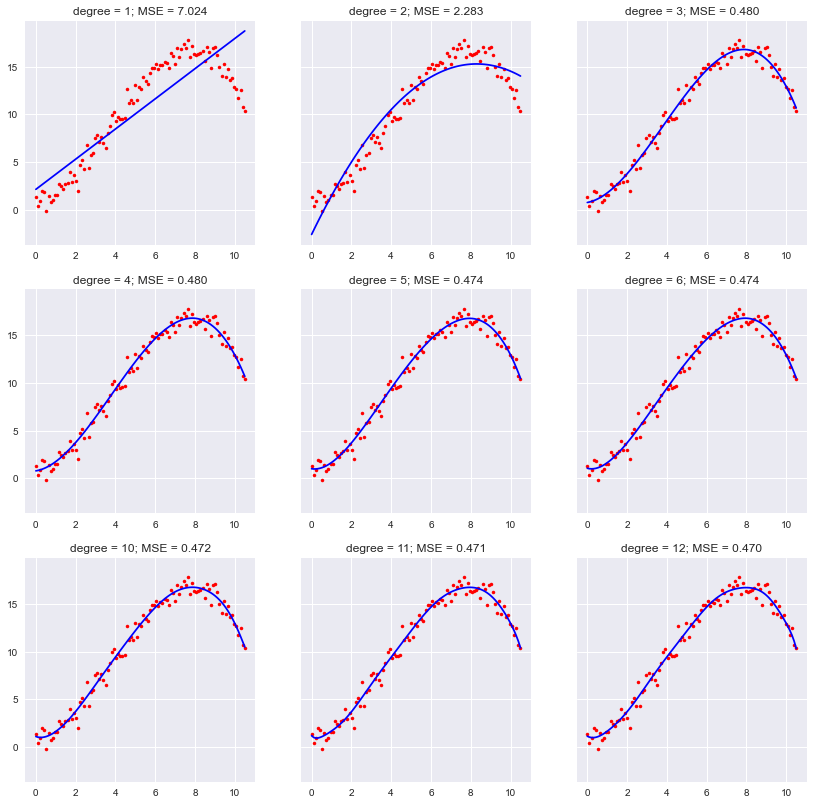

In [121]:
# TODO: generate the sequence of degrees, call test_polynomials to create models,
#       use plot_predictions to show the results
polynomials = [1,2,3,4,5,6,10,11,12]
pred_list, error_list = test_polynomials(polynomials)
plot_predictions(polynomials, pred_list, error_list)

#### 1.2 Discuss the results seen in the plots above

**Discussion**:  The results show a few key things. Our model has the smallest MSE at degree 12, but the models with degrees 3 and higher are relatively close to each other. The models with degrees less than 3 (1 and 2) do particularly pooly. Overall, we can see that models with degrees 3 and up are best. 

### 2. $k$-fold cross-validation 

For each of the polynomial degrees, 5-fold cross-validation is performed.  Data is divided into 5 equal parts, and 5 separate models are trained and tested.  Results are averaged over the 5 runs and plotted (in a single plot), comparing training and test error for each of the polynomial degrees.  Error values are also shown in a tabular form.

#### Creating the $k$ folds

A function that generates the distinct, non-overlapping folds of the data.  (**Don't modify this.**)

In [122]:
# A simple function for generating different data-folds.
#
# DO NOT MODIFY THIS CODE.
def make_folds(x_data, y_data, num_folds=1):
    '''Splits data into num_folds separate folds for cross-validation.
       Each fold should consist of M consecutive items from the
       original data; each fold should be the same size (we will assume 
       that  the data divides evenly by num_folds).  Every data item should 
       appear in exactly one fold.
       
       Args
       ----
       x_data: input data.
       y_data: matching output data.
           (Expected that these are of the same length.)
       num_folds : some positive integer value
           Number of folds to divide data into.
           
        Returns
        -------
        x_folds : list of sub-sequences of original x_data 
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
        y_folds : list of sub-sequences of original y_data
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
       '''
    x_folds = list()
    y_folds = list()
    
    foldLength = (int)(len(x_data) / num_folds)
    start = 0
    for fold in range(num_folds):
        end = start + foldLength
        x_folds.append(x_data[start:end])
        y_folds.append(y_data[start:end])
        start = start + foldLength
        
    return x_folds, y_folds

In [123]:
# Print out start/end of each fold for sanity check.  Should see 5 folds,
# with the (x,y) pairs at the start/end of each.  (Can be manually verified 
# by looking at original input file.)
#
# DO NOT MODIFY THIS CODE.
k = 5
x_folds, y_folds = make_folds(x, y, k)
for i in range(k):
    print("Fold %d: (%.3f, %.3f) ... (%.3f, %.3f)"
         % (i, x_folds[i][0], y_folds[i][0], x_folds[i][-1], y_folds[i][-1]))

Fold 0: (1.591, 2.847) ... (10.394, 10.739)
Fold 1: (6.788, 16.408) ... (2.227, 4.722)
Fold 2: (9.545, 13.897) ... (3.924, 10.229)
Fold 3: (2.864, 5.929) ... (7.212, 16.030)
Fold 4: (7.530, 16.982) ... (0.848, 0.990)


#### 2.1 Perform cross-validation

For each of the polynomial degrees already considered, $k$-fold cross-validation is performed.  Average training error (MSE) and test error (MSE) are reported, both in the form of a plot and a tabular print of the values.

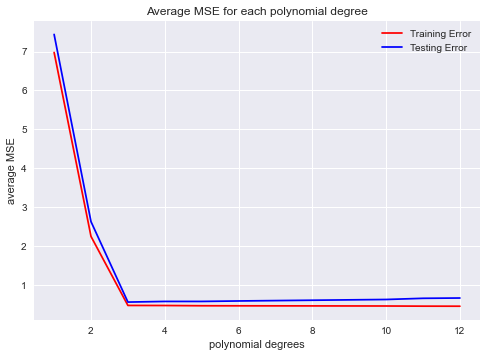

,Mean Train-error,Mean Test-error
1,6.977641,7.441157
2,2.245920,2.625608
3,0.471621,0.558083
4,0.469909,0.574623
5,0.463663,0.574580
6,0.462069,0.586606
10,0.457199,0.624748
11,0.453294,0.654944
12,0.451891,0.662586


In [124]:
# TODO: Perform 5-fold cross-validation for each polynomial degree.  
#       Keep track of average training/test error for each degree; 
#       Plot results in a single table, properly labeled, and also
#       print out the results in some clear tabular format.

# polynomials
polynomials = [1,2,3,4,5,6,10,11,12]

# averages
train_averages = list()
test_averages = list()

# divide the input into k diff test sets
k = 5
x_folds, y_folds = make_folds(x, y, k)

# looping through polynomials
for degree in range(len(polynomials)):
    
    # initializing prediction/error lists
    prediction_list = list()
    error_list_train = list()
    prediction_list_test = list()
    error_list_test = list()
    
    # looping through folds, remove one at a time
    for fold in range(k):
        
        # for each run, remove one of the test sets
        x_train_sets = x_folds.copy()
        x_test_set = x_train_sets.pop(fold)
        y_train_sets = y_folds.copy()
        y_test_set = y_train_sets.pop(fold)
        
        # convert train sets into array of data instead of array of 4 folds of data
        curr_set = list()
        curr_set_y = list()
        for i in range(4):
            for j in range(len(x_train_sets[i])):
                curr_set.append(x_train_sets[i][j])
                curr_set_y.append(y_train_sets[i][j])
            
        # train on the remainder
        poly = PolynomialFeatures(polynomials[degree])
        transformed_X = poly.fit_transform(curr_set)
        lin_reg = linear_model.LinearRegression()
        lin_reg.fit(transformed_X, curr_set_y)

        # predict with training data, find training error
        y_pred = lin_reg.predict(transformed_X)
        prediction_list.append(y_pred)
        error_list_train.append(mean_squared_error(curr_set_y, prediction_list[fold]))
        
        # test on the other set
        y_pred = lin_reg.predict(poly.fit_transform(x_test_set))
        prediction_list_test.append(y_pred)
        error_list_test.append(mean_squared_error(y_test_set, prediction_list_test[fold]))
        
        
    # average the k results to estimate true error
    train_averages.append(sum(error_list_train) / len(error_list_train))
    test_averages.append(sum(error_list_test) / len(error_list_test))

    
# plotting results
plt.plot(polynomials, train_averages, color="red", label="Training Error")
plt.plot(polynomials, test_averages, color="blue", label="Testing Error")

plt.title("Average MSE for each polynomial degree")
plt.xlabel("polynomial degrees")
plt.ylabel("average MSE")
plt.legend()
plt.show()

# showing results in table
dic = {'Mean Train-error': train_averages, 'Mean Test-error': test_averages}
df = pd.DataFrame.from_dict(dic)
df.index = polynomials
df

#### 2.2 Discuss the results seen in the plots above

**Discussion:** The results show a few key things. When we graph the relationship of the polynomial degrees and MSE, we see that both the training set averages and testing set averages are relatively close. They both sharply decrease between degrees 1 and 3, and are around .5 MSE for higher polynomials. When trying to find the optimal degree, we look for the smallest MSE for testing error. Thus, our optimal degree is 3. 

In this plot, we can see that there is underfitting in degrees 1-2 because neither error is minimized. We also see that there is overfitting 4 and higher because the training error is much lower but the testing error is increasing.

### 3. Regularized (ridge) regression

Ridge regularization is a process whereby the loss function that is minimized combines the usual measure (error on the training data) with a penalty that is applied to the magnitude of individual coefficients.  This latter penalty discourages models that overly emphasize any single feature, and can often prevent over-fitting.

Here, a set of 50 different `sklearn.linear_model.Ridge` models are generated, each using a single polynomial degree (the one that was determined to be best for the data-set in earlier tests), and using a range of different regularization penalties, chosen from a logarithmic series: $s \in [0.01, 100]$.  5-fold cross-validation is again used to examine how robust these models are.

#### 3.1 Cross-validation for each regularization strength value

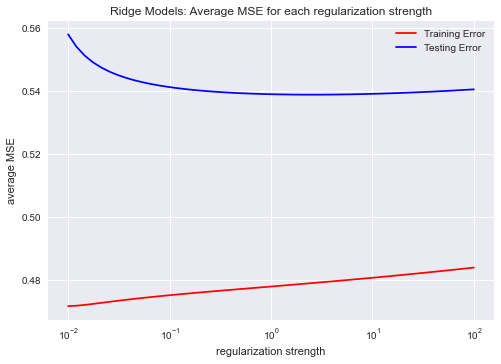

,Regularization Strength,Mean Train-error,Mean Test-error
0,0.010000,0.471621,0.558083
1,0.012068,0.471739,0.554145
2,0.014563,0.471998,0.551308
3,0.017575,0.472314,0.549175
4,0.021210,0.472649,0.547517
5,0.025595,0.472985,0.546193
6,0.030888,0.473311,0.545113
7,0.037276,0.473626,0.544218
8,0.044984,0.473928,0.543464
9,0.054287,0.474218,0.542823


In [126]:
# TODO: Generate a sequence of 50 ridge models, varying the regularization strength
#       from 0.01 (10^-2) to 100 (10^2).  Each model is 5-fold cross-validated and
#       the resulting average training/test errors are tracked.  Errors are then
#       plotted (on a logarithmic scale) and printed in some legible tabular form.

strengths = np.logspace(-2, 2, base=10, num=50)

# averages
train_averages = list()
test_averages = list()

for weight in range(len(strengths)):

    prediction_list = list()
    error_list_train = list()
    prediction_list_test = list()
    error_list_test = list()
    
    # looping through folds, remove one at a time
    for fold in range(k):
        
        # for each run, remove one of the test sets
        x_train_sets = x_folds.copy()
        x_test_set = x_train_sets.pop(fold)
        y_train_sets = y_folds.copy()
        y_test_set = y_train_sets.pop(fold)
        
        # convert train sets into array of data instead of array of 4 folds of data
        curr_set = list()
        curr_set_y = list()
        for i in range(4):
            for j in range(len(x_train_sets[i])):
                curr_set.append(x_train_sets[i][j])
                curr_set_y.append(y_train_sets[i][j])
            
        # train on the remainder
        poly = PolynomialFeatures(3)
        transformed_X = poly.fit_transform(curr_set)
        lin_reg = linear_model.Ridge(weight)
        lin_reg.fit(transformed_X, curr_set_y)

        # predict with training data, find training error
        y_pred = lin_reg.predict(transformed_X)
        prediction_list.append(y_pred)
        error_list_train.append(mean_squared_error(curr_set_y, prediction_list[fold]))
        
        # test on the other set
        y_pred = lin_reg.predict(poly.fit_transform(x_test_set))
        prediction_list_test.append(y_pred)
        error_list_test.append(mean_squared_error(y_test_set, prediction_list_test[fold]))
        
        
    # average the k results to estimate true error
    train_averages.append(sum(error_list_train) / len(error_list_train))
    test_averages.append(sum(error_list_test) / len(error_list_test))
    
# plotting results
plt.xscale('log')
plt.plot(strengths, train_averages, color="red", label="Training Error")
plt.plot(strengths, test_averages, color="blue", label="Testing Error")

plt.title("Ridge Models: Average MSE for each regularization strength")
plt.xlabel("regularization strength")
plt.ylabel("average MSE")
plt.legend()
plt.show()

# showing results in table
dic = {'Regularization Strength': strengths,'Mean Train-error': train_averages, 'Mean Test-error': test_averages}
df = pd.DataFrame.from_dict(dic)
df

#### 3.2 Discuss the results seen in the plots above

**Discussion**:  From lowest strength to highest strength in our range, the results show a few things. The training error slowly increase from 0.47 to 0.48. The testing error starts at 0.56, dips to 0.53, and rises to 0.54. Increasing regularization avoids overfitting because the testing error doesn't drastically increase once the strength is past the optimal alpha. The effect is less useful for very low strengths and very high ones, because the testing error isn't as low.